In [1]:

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller

import pmdarima as pm

In [2]:
df = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv") # insérer le chemin d'accès au jeu de données

#string to date format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
df.head(5)

df_bis = pd.read_csv("C:/Users/maelm/Documents/L2/PROJET S3/Apple/AAPL.csv")[7950:8200] # insérer le chemin d'accès au jeu de données
df_bis['Date'] = pd.to_datetime(df_bis['Date'],infer_datetime_format=True)
df_bis = df_bis.set_index(['Date'])

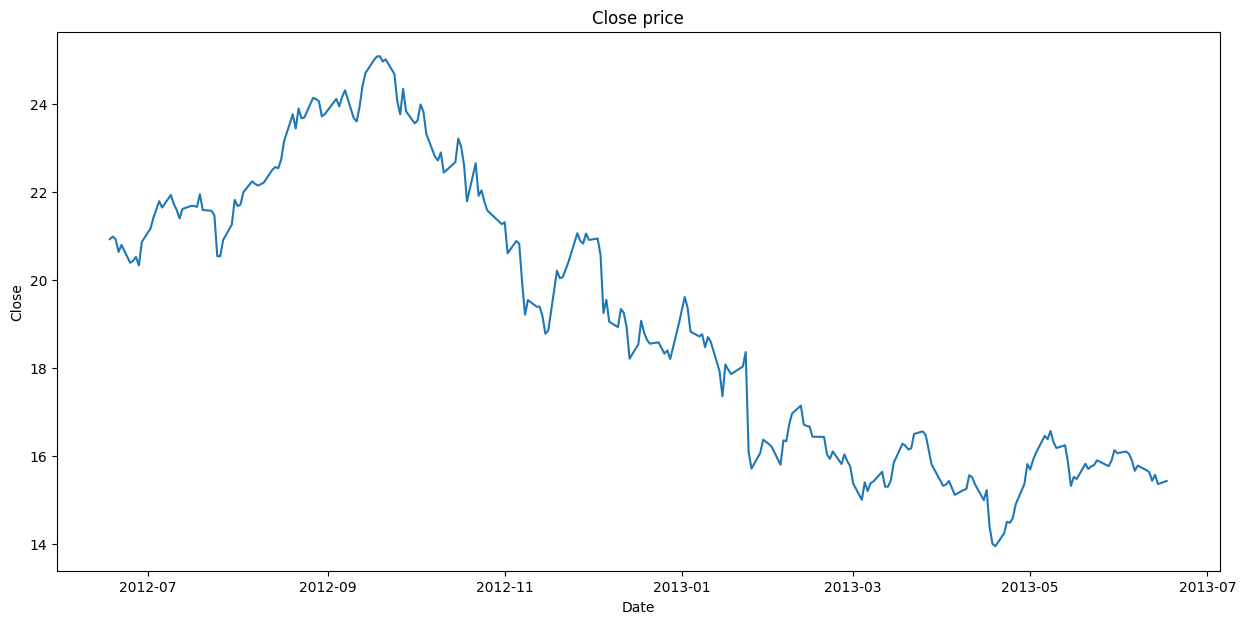

In [3]:
# 21 septembre 2012 : 8019
# 20 septembre 2013 : 8268


plt.figure(figsize=(15,7))
plt.title("Close price")
plt.xlabel('Date')
plt.ylabel('Close')
plt.plot(df_bis['Close'])

plt.show()

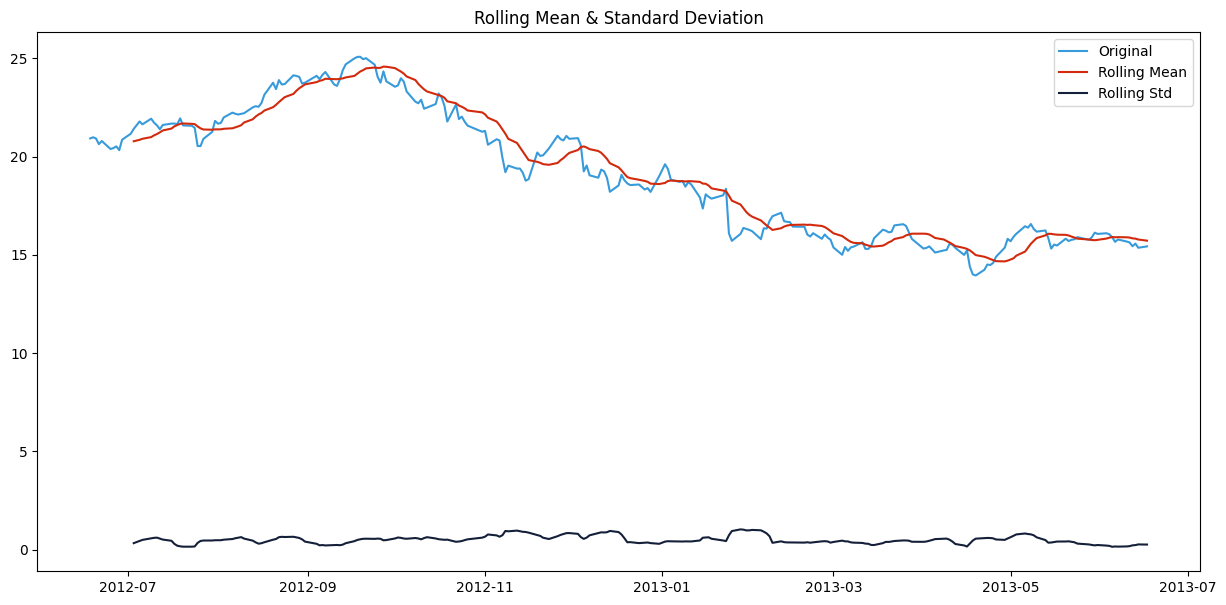

In [4]:
#Determine rolling statistics
df["rolling_avg"] = df_bis["Close"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
df["rolling_std"] = df_bis["Close"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_bis["Close"], color='#379BDB', label='Original')
plt.plot(df["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [5]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_bis['Close'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -0.623666
p-value                          0.865544
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


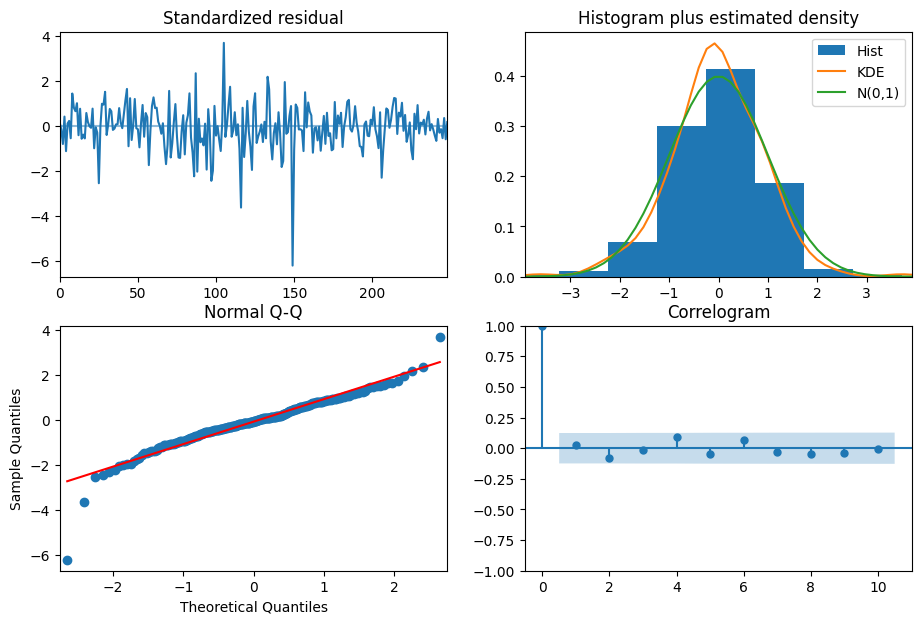

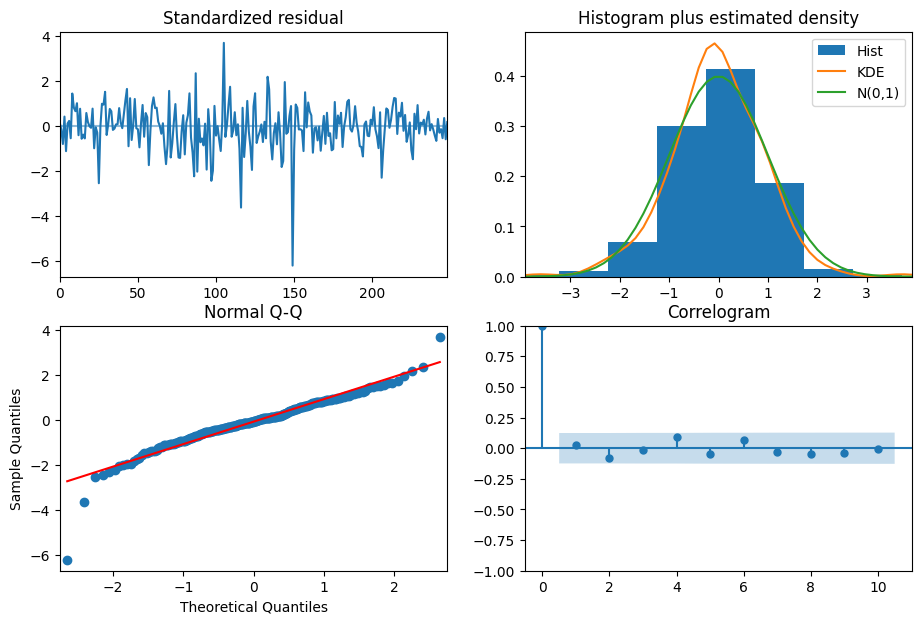

In [26]:
# prédiction
ARIMA_model = pm.auto_arima(df_bis['Close'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      # let model determine 'd'
                      seasonal=True, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

# ARIMA_model.plot_diagnostics(figsize=(11,7)) pour voir le détail du modèle

C:\Users\maelm\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


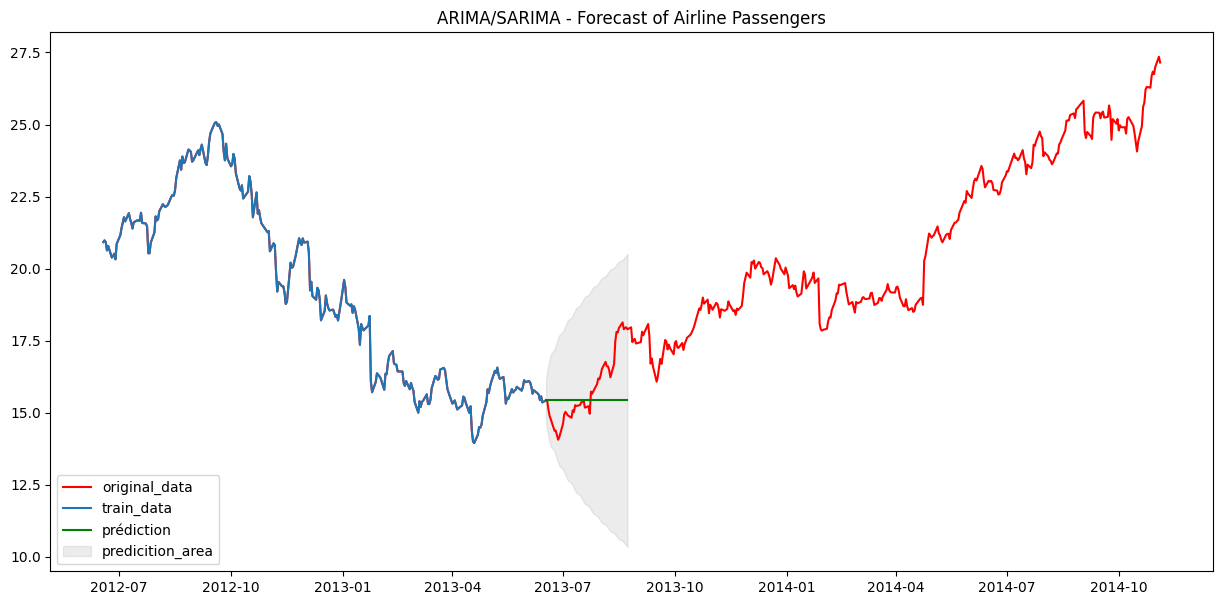

In [19]:
# affichage prédiction 
def forecast(ARIMA_model, periods=50):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True, levels=1)
    index_of_fc = pd.date_range(df_bis.index[-1] + pd.DateOffset(day=0), periods = n_periods, freq='B')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted.array, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df['Close'][7950:8550], color='red', label ="original_data")
    plt.plot(df_bis["Close"], color='#1f76b4', label="train_data")
    plt.plot(fitted_series, color='green', label="prédiction")
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series,
                    label="predicition_area", 
                    color='grey', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.legend()
    plt.show()

forecast(ARIMA_model)
